# Hole Markings Detector


## Imports

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.2.0


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4065, done.
remote: Counting objects: 100% (4065/4065), done.
remote: Compressing objects: 100% (3090/3090), done.
remote: Total 4065 (delta 1186), reused 1953 (delta 915), pack-reused 0
Receiving objects: 100% (4065/4065), 54.71 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (1186/1186), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [ ]:
# Load images and visualize

train_image_dir= '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/'
train_images_np = []
for i in range(1, 33):
  image_path = os.path.join(train_image_dir, 'img' + str(i) + '.jpg')
  print(image_path)
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]


/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img1.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img2.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img3.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img4.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img5.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img6.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img7.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/images/img8.jpg
/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train

# Label Inputs

Run this cell to input the labels for the bounding boxes of the images in the training dataset

In [ ]:
gt_boxes = []

train_label_dir = '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/train/labels/'
for img_no in range(32):
  label_path = os.path.join(train_label_dir, str(img_no) + '.txt')
  with open(label_path, 'r') as labels:
    newarr = []
    for k in range(10):  # as there are 10 occurances of the class
      annotations = labels.readline()
      mylist = annotations.split()
      width = float(mylist[3])
      height = float(mylist[4])
      x_min = float(mylist[1]) - (width/2)
      x_max = float(mylist[1]) + (width/2)
      y_min = float(mylist[2]) - (height/2)
      y_max = float(mylist[2]) + (height/2)
      myarr = [y_min, x_min, y_max, x_max]
      newarr.append(myarr)
    newarr = np.array(newarr)
    gt_boxes.append(newarr)

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
cross_class_id = 1
num_classes = 1

category_index = {cross_class_id: {'id': cross_class_id, 'name': 'X-mark'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Visualizing images with annotations / bounding boxes



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


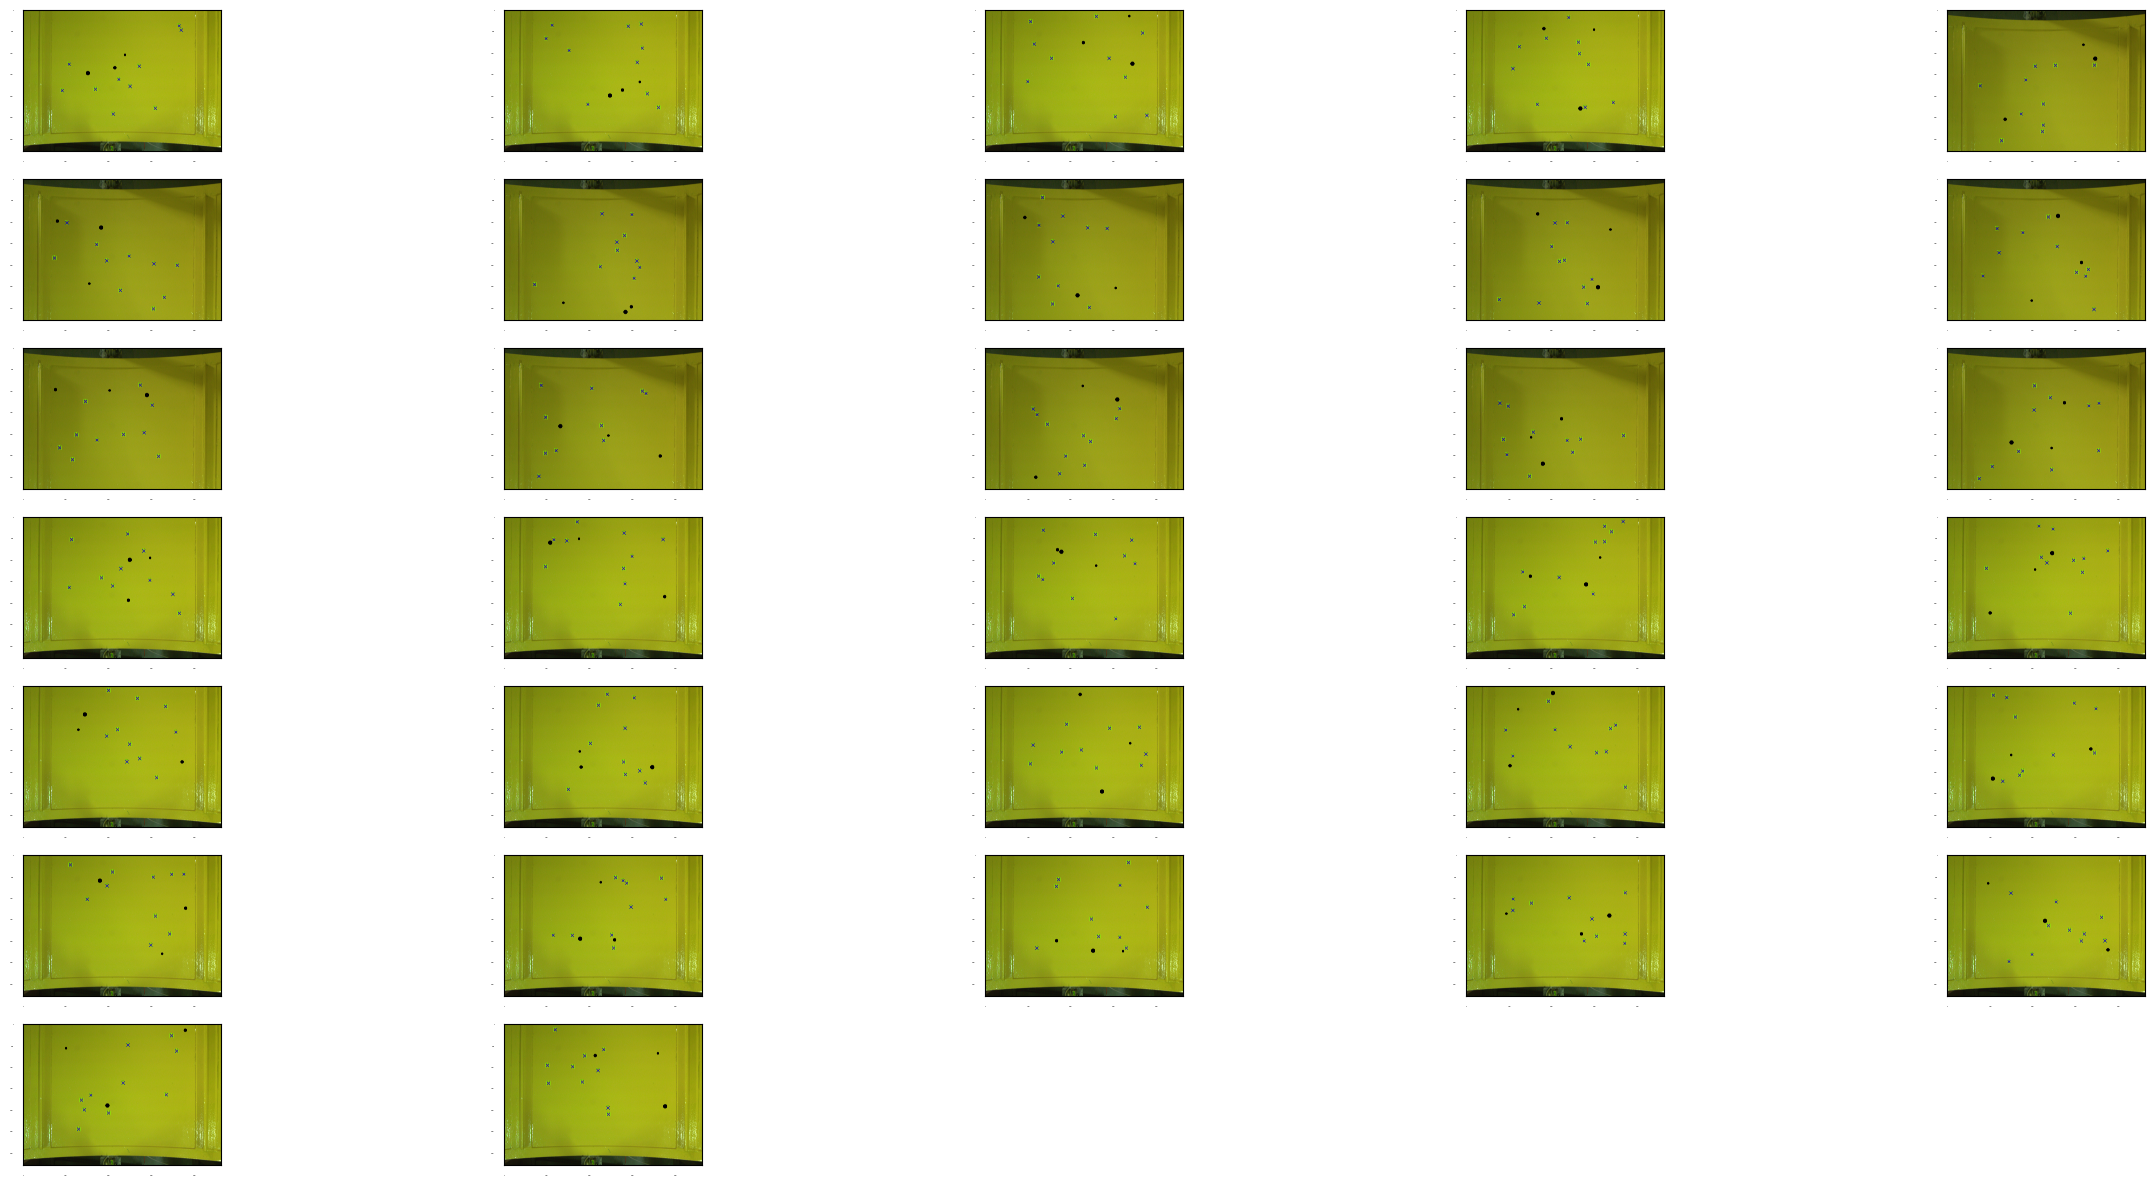

Sanity check Done.


In [ ]:
#dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
#originally used for passing a single item array but doesn't work with multiple detections so edited
dummy_scores = np.ones(shape=[gt_boxes[0].shape[0]], dtype=np.float32)

plt.figure(figsize=(30, 15))
for idx in range(32):
  print(idx)
  plt.subplot(7, 5, idx+1)
  plot_detections(
    train_images_np[idx],
    gt_boxes[idx],
    np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
    dummy_scores, category_index)
plt.show()
print('Sanity check Done.')

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, there are a number of things in this colab that have been hardcoded for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640).

In [ ]:
# Downloaing the checkpoint and put it into models/research/object_detection/test_data/
# To run RetinaNet (SSD)

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2023-12-13 01:01:50--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   261MB/s    in 0.9s    

2023-12-13 01:01:51 (261 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
# Downloading the checkpoint and put it into models/research/object_detection/test_data/
# To run EfficientDet

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d1_coco17_tpu-32.tar.gz
!mv /content/efficientdet_d1_coco17_tpu-32/checkpoint models/research/object_detection/test_data/

In [ ]:
print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
# pipeline_config = 'models/research/object_detection/configs/tf2/ssd_efficientdet_d1_640x640_coco17_tpu-8.config
# uncomment the line above and comment the other pipeline_config to run EfficientDet instead of RetinaNet (SSD)
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
output_metrics_dir = '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/out/images/'

#Writing Training data in a file
def printTrain(headerYesNo,BatchNo,NoOfBatches,t_Loss):
  import datetime;
  metrics_path = os.path.join(output_metrics_dir, 'train_metrics.csv')
  if os.path.isfile(metrics_path):
    FirstTime = False
  else:
    FirstTime = True
  file1 = open(metrics_path,"a")
  if headerYesNo == "Yes":
    if FirstTime:
      file1.write('Time,' + 'BatchNo,' + 'Total Batches,' + 'Loss' + '\n')
  elif headerYesNo == "No":
    ct = datetime.datetime.now()
    file1.write(str(ct) + ',' + str(BatchNo) + ',' + str(NoOfBatches) + ',' + str(t_Loss) + '\n')
  else:
    file1.close
    print('Writing completed!')

#Writing prediction score in a file
def printPred(headerYesNo,fileNum):
  import datetime;
  metrics_path = os.path.join(output_metrics_dir, 'prediction.csv')
  if os.path.isfile(metrics_path):
    FirstTime = False
  else:
    FirstTime = True

  file2 = open(metrics_path,"a")
  if headerYesNo == "Yes":
    if FirstTime:
      file2.write('Batch,' + 'Image,' + 'Sno#,' + 'Prediction' + '\n')
  elif headerYesNo == "No":
    #ct = datetime.datetime.now()
    myPred = detections['detection_scores'][0].numpy()
    for j in range(10):
      file2.write('BatchSize:'+str(batch_size)+'_NumBatches:'+str(num_batches) + ',' + str(fileNum+1) + ',' + str(j+1) + ',' + str(myPred[j]) + '\n')
  else:
    file2.close
    print('Writing completed!')

# Training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 16
learning_rate = 0.01 #0.01
num_batches = 300 #100
#Writing training stats in a file
printTrain("Yes",1,num_batches,1)

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)
    #Writing training metrics into file
    printTrain("No",idx,num_batches,total_loss.numpy())

printTrain("Close",1,1,1)
print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 300, loss=3.8154275
batch 10 of 300, loss=7.89618
batch 20 of 300, loss=10.614677
batch 30 of 300, loss=2.8090172
batch 40 of 300, loss=1.6176864
batch 50 of 300, loss=5.1427293
batch 60 of 300, loss=1.8937097
batch 70 of 300, loss=5.1945395
batch 80 of 300, loss=3.9648943
batch 90 of 300, loss=2.281294
batch 100 of 300, loss=3.4691794
batch 110 of 300, loss=18.43664
batch 120 of 300, loss=10.896821
batch 130 of 300, loss=7.3002286
batch 140 of 300, loss=4.6163774
batch 150 of 300, loss=7.542434
batch 160 of 300, loss=2.9717872
batch 170 of 300, loss=28.543705
batch 180 of 300, loss=7.420046
batch 190 of 300, loss=3.307368
batch 200 of 300, loss=3.4536185
batch 210 of 300, loss=4.240896
batch 220 of 300, loss=5.391131
batch 230 of 300, loss=1.6142557
batch 240 of 300, loss=1.3390784
batch 250 of 300, loss=1.8942612
batch 260 of 300, loss=0.6240994
batch 270 of 300, loss=11.783449
batch 280 of 300, loss=24.992136
batch 290 of 300, loss=12.811833
Writing completed!
Done fine-t

# Loading test images and running inference

In [ ]:
test_image_dir = '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/val/images/'
output_image_dir = '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/out/images/'
test_images_np = []
for i in range(402, 412):
  image_path = os.path.join(test_image_dir, str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
printPred('Yes',1)
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name=os.path.join(output_image_dir,"gif_frame_" + ('%02d' % i) + ".jpg"))
  printPred('No',i)
printPred('close',1)

Writing completed!


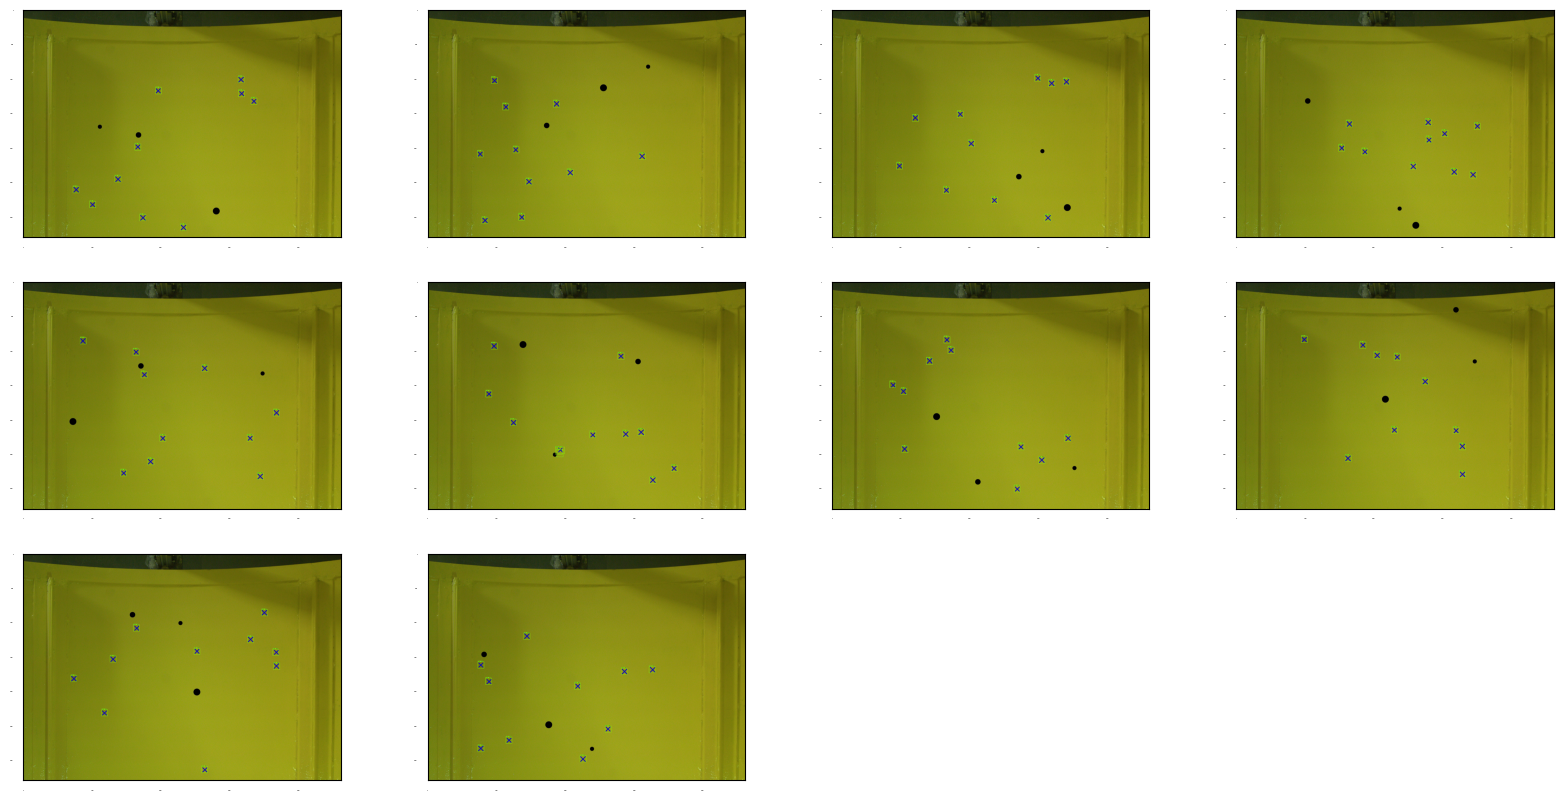

In [ ]:
# Finally print the output image with predicted bounding box in it

output_image_dir= '/content/drive/MyDrive/models/research/object_detection/test_images/mini_dataset_generated/out/images/'
output_images_np = []
for i in range(10):
  image_path = os.path.join(output_image_dir, 'gif_frame_' + ('%02d' % i) + '.jpg')
  output_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [20, 10]

for idx, output_image_np in enumerate(output_images_np):
  plt.subplot(3, 4, idx+1)
  plt.imshow(output_image_np)
plt.show()


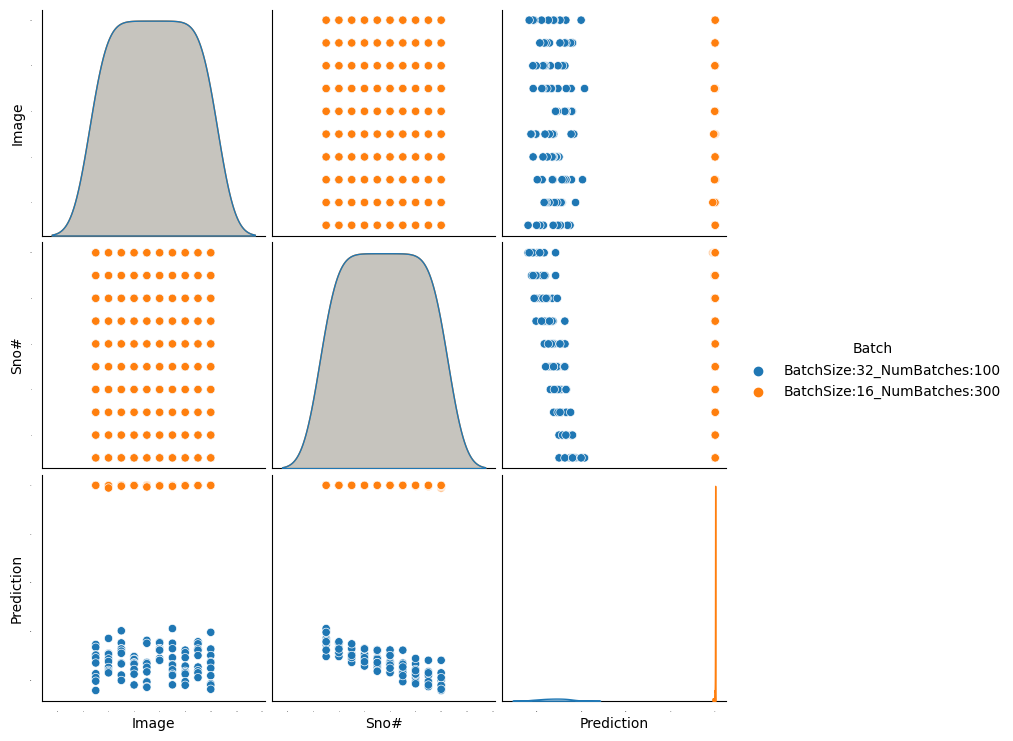

In [ ]:
#Comparision
# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# reading the database
data = pd.read_csv(metrics_path)
sns.pairplot(data=data, hue="Batch")
plt.show()